# Mudcard answers
- NA

## Missing data

By the end of this module, you will be able to
- apply multivariate imputation
- apply XGBoost to a dataset with missing values
- apply the reduced-features model (also called the pattern submodel approach)
- decide which approach is best for your dataset

## We continue working with the house price data set
- regression problem
- categorical, ordinal, continuous features
- missing data in all feature types

In [3]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# Let's load the data
df = pd.read_csv('data/train.csv')

# drop the ID
df.drop(columns=['Id'],inplace=True)

# the target variable
y = df['SalePrice']
df.drop(columns=['SalePrice'],inplace=True)

# the unprocessed feature matrix
X = df.values
print(X.shape)

# the feature names
ftrs = df.columns

(1460, 79)


In [4]:
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
print('data types of the features with missing values:')
print(df[perc_missing_per_ftr[perc_missing_per_ftr > 0].index].dtypes)
frac_missing = sum(df.isnull().sum(axis=1)!=0)/df.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
LotFrontage     0.177397
Alley           0.937671
MasVnrType      0.597260
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
FireplaceQu     0.472603
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
PoolQC          0.995205
Fence           0.807534
MiscFeature     0.963014
dtype: float64
data types of the features with missing values:
LotFrontage     float64
Alley            object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
FireplaceQu      object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
PoolQC           object
Fence         

In [5]:
# let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(876, 79)
(292, 79)
(292, 79)


In [6]:
# collect the various features
cat_ftrs = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2',\
            'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',\
           'Heating','CentralAir','Electrical','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
ordinal_ftrs = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',\
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',\
               'GarageQual','GarageCond','PoolQC','Fence']
ordinal_cats = [['Reg','IR1','IR2','IR3'],['AllPub','NoSewr','NoSeWa','ELO'],['Gtl','Mod','Sev'],\
               ['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Po','Fa','TA','Gd','Ex'],['NA','No','Mn','Av','Gd'],['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],\
               ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],\
               ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Unf','RFn','Fin'],['NA','Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],
               ['NA','Fa','TA','Gd','Ex'],['NA','MnWw','GdWo','MnPrv','GdPrv']]
num_ftrs = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',\
             'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
             'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
             'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

In [7]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [8]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)

(876, 220)
(292, 220)
(292, 220)


In [9]:
feature_names

array(['num__MSSubClass', 'num__LotFrontage', 'num__LotArea',
       'num__OverallQual', 'num__OverallCond', 'num__YearBuilt',
       'num__YearRemodAdd', 'num__MasVnrArea', 'num__BsmtFinSF1',
       'num__BsmtFinSF2', 'num__BsmtUnfSF', 'num__TotalBsmtSF',
       'num__1stFlrSF', 'num__2ndFlrSF', 'num__LowQualFinSF',
       'num__GrLivArea', 'num__BsmtFullBath', 'num__BsmtHalfBath',
       'num__FullBath', 'num__HalfBath', 'num__BedroomAbvGr',
       'num__KitchenAbvGr', 'num__TotRmsAbvGrd', 'num__Fireplaces',
       'num__GarageYrBlt', 'num__GarageCars', 'num__GarageArea',
       'num__WoodDeckSF', 'num__OpenPorchSF', 'num__EnclosedPorch',
       'num__3SsnPorch', 'num__ScreenPorch', 'num__PoolArea',
       'num__MiscVal', 'num__MoSold', 'num__YrSold',
       'cat__MSZoning_C (all)', 'cat__MSZoning_FV', 'cat__MSZoning_RH',
       'cat__MSZoning_RL', 'cat__MSZoning_RM', 'cat__Street_Grvl',
       'cat__Street_Pave', 'cat__Alley_Grvl', 'cat__Alley_Pave',
       'cat__Alley_missing', 'ca

In [10]:
print('data dimensions:',df_train.shape)
perc_missing_per_ftr = df_train.isnull().sum(axis=0)/df_train.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(df_train.isnull().sum(axis=1)!=0)/df_train.shape[0]
print('fraction of points with missing values:',frac_missing)

data dimensions: (876, 220)
fraction of missing values in features:
num__LotFrontage    0.173516
num__MasVnrArea     0.004566
num__GarageYrBlt    0.050228
dtype: float64
fraction of points with missing values: 0.2237442922374429


Missing values in ordinal and categorical features already imputed with NA, we are only dealing with numeric missing values now.

## <font color='LIGHTGRAY'>Missing data</font>

<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
- **apply multivariate imputation**
- <font color='LIGHTGRAY'>apply XGBoost to a dataset with missing values</font>
- <font color='LIGHTGRAY'>apply the reduced-features model (also called the pattern submodel approach)</font>
- <font color='LIGHTGRAY'>decide which approach is best for your dataset</font>

### Multivariate Imputation

- models each feature with missing values as a function of other features, and uses that estimate for imputation
   - at each step, a feature is designated as target variable and the other feature columns are treated as feature matrix X
   - a regressor is trained on (X, y) for known y
   - then, the regressor is used to predict the missing values of y
- in the ML pipeline:
   - create n imputed datasets
   - run all of them through the ML pipeline
   - generate n test scores
   - the uncertainty in the test scores is due to the uncertainty in imputation
- paper [here](https://www.jstatsoft.org/article/view/v045i03)

### sklearn's IterativeImputer

In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

print(df_train[['num__LotFrontage','num__MasVnrArea','num__GarageYrBlt']].head())

imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=1), random_state=42)
# imputer = IterativeImputer(estimator = LinearRegression(), random_state=42)
X_impute = imputer.fit_transform(df_train)
df_train_imp = pd.DataFrame(data=X_impute, columns = df_train.columns)

print(df_train_imp[['num__LotFrontage','num__MasVnrArea','num__GarageYrBlt']].head())

df_CV_imp = pd.DataFrame(data=imputer.transform(df_CV), columns = df_train.columns)
df_test_imp = pd.DataFrame(data=imputer.transform(df_test), columns = df_train.columns)

   num__LotFrontage  num__MasVnrArea  num__GarageYrBlt
0          0.424926        -0.573303          0.979398
1               NaN         0.492835          1.018748
2               NaN        -0.573303          0.192399
3         -0.049970         0.810076         -0.476551
4         -1.474659        -0.022031          0.979398
   num__LotFrontage  num__MasVnrArea  num__GarageYrBlt
0          0.424926        -0.573303          0.979398
1         -1.647349         0.492835          1.018748
2          0.424926        -0.573303          0.192399
3         -0.049970         0.810076         -0.476551
4         -1.474659        -0.022031          0.979398


### Does it make sense to impute?
- GarageYearBuilt should definitely not be imputed because a missing value indicates no garage on the property

## Quiz 1

Replace the RandomForestRegressor with a linear regression model. Rerun the imputation a couple of times. What changes? Why is this a problem?

**Answer:** Linear regression is deterministic so the imputed values do not change when you rerun the code. This is bad because you will not be able to assess how uncertainty of imputation impacts the predictive power of your models.

In [12]:
print(df_train[['num__LotFrontage','num__MasVnrArea','num__GarageYrBlt']].head())

imputer = IterativeImputer(estimator = LinearRegression(), random_state=42)
X_impute = imputer.fit_transform(df_train)
df_train_imp = pd.DataFrame(data=X_impute, columns = df_train.columns)

print(df_train_imp[['num__LotFrontage','num__MasVnrArea','num__GarageYrBlt']].head())

df_CV_imp = pd.DataFrame(data=imputer.transform(df_CV), columns = df_train.columns)
df_test_imp = pd.DataFrame(data=imputer.transform(df_test), columns = df_train.columns)

   num__LotFrontage  num__MasVnrArea  num__GarageYrBlt
0          0.424926        -0.573303          0.979398
1               NaN         0.492835          1.018748
2               NaN        -0.573303          0.192399
3         -0.049970         0.810076         -0.476551
4         -1.474659        -0.022031          0.979398
   num__LotFrontage  num__MasVnrArea  num__GarageYrBlt
0          0.424926        -0.573303          0.979398
1         -1.844555         0.492835          1.018748
2         -0.676506        -0.573303          0.192399
3         -0.049970         0.810076         -0.476551
4         -1.474659        -0.022031          0.979398


## <font color='LIGHTGRAY'>Missing data</font>

<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
- <font color='LIGHTGRAY'>apply multivariate imputation</font>
- **apply XGBoost to a dataset with missing values**
- <font color='LIGHTGRAY'>apply the reduced-features model (also called the pattern submodel approach)</font>
- <font color='LIGHTGRAY'>decide which approach is best for your dataset</font>

## XGBoost
- eXtreme Gradient Boosting - a popular tree-based method
- [blog post](https://xgboost.readthedocs.io/en/latest/tutorials/model.html) and [paper](http://delivery.acm.org/10.1145/2940000/2939785/p785-chen.pdf)
   -  decision tree ensembles: classification and regression trees (CART) -- associate scores to trees & ensemble
   -  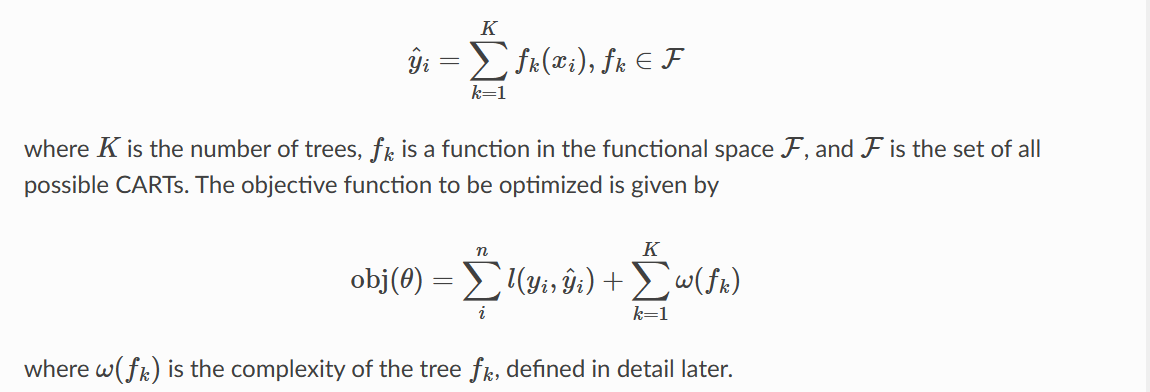
- more advanced than random forest
   - it has l1 and l2 regularization while random forest does not
   - trees are not independent
      - the next tree is built to improve the previous tree
      - less trees are necessary to achieve same accuracy
      - but XGBoost trees can overfit - more on this in the problem set
   - handles missing values well

## XGBoost and missing values
- sklearn raises an error if the feature matrix (X) contains nans - but see [here](https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values)
- XGBoost doesn't! 
- If a feature with missing values is split:
    - XGBoost tries to put the points with missing values to the left and right
    - calculates a metric called gain for both options
    - puts the points with missing values to the side with the higher gain
- if missingness correlates with the target variable, XGBoost extracts this info!

In [16]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "missing": [np.nan], 
              #"max_depth": [1, 3, 10, 30, 100],
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor()
XGB.set_params(**ParameterGrid(param_grid)[0]) # ONLY THE ONE MODEL IS TRAINED HERE!
XGB.fit(df_train, y_train, early_stopping_rounds=50, eval_set=[(df_CV, y_CV)], verbose=False)
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 23774.18106238455
the test RMSE: 32847.275777137525
the test R2: 0.8437638333292397


### XGB notes
- do not tune the number of trees, set it to a very large value like 10000
- use early stopping instead! it will automatically determine the best number of trees based on a validation set.
- there are a large number of hyperparameters in XGB
    - tune maybe `max_depth`, `reg_alpha`, and `reg_lambda`
- the default values of some hyperparameters are not optimal
    - set `colsample_bytree` and `subsample` to values a bit smaller than 1 to avoid overfitting

## Quiz 2
How many trees does the XGBoost model trained on the dataset have? Look up on stackoverflow or the XGBoost manual how to determine it.

In [17]:
dump_list = XGB.get_booster().get_dump()
num_trees = len(dump_list)
print(num_trees)

426


In [18]:
XGB.best_iteration

375

## <font color='LIGHTGRAY'>Missing data</font>

<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
- <font color='LIGHTGRAY'>apply multivariate imputation</font>
- <font color='LIGHTGRAY'>apply XGBoost to a dataset with missing values</font>
- **apply the reduced-features model (also called the pattern submodel approach)**
- <font color='LIGHTGRAY'>decide which approach is best for your dataset</font>

## Reduced-features model (or pattern submodel approach)
- first described in 2007 in a [JMLR article](http://www.jmlr.org/papers/v8/saar-tsechansky07a.html) as the reduced features model
- in 2018, "rediscovered" as the pattern submodel approach in [Biostatistics](https://www.ncbi.nlm.nih.gov/pubmed/30203058)

<center>My test set:</center>

| index | feature 1 | feature 2 | feature 3 | target var |
|- | :-: | :-: | :-: | :-: |
| 0     	|     <font color='red'>NA</font>    	|     45    	|     <font color='red'>NA</font>    	|      0     	|
| 1     	|     <font color='red'>NA</font>    	|     <font color='red'>NA</font>    	|     8     	|      1     	|
| 2     	|     12    	|     6     	|     34    	|      0     	|
| 3     	|     1     	|     89    	|     <font color='red'>NA</font>    	|      0     	|
| 4     	|     0     	|     <font color='red'>NA</font>    	|     47    	|      1     	|
| 5     	|    687    	|     24    	|     67    	|      1     	|
| 6     	|     <font color='red'>NA</font>    	|     23    	|     <font color='red'>NA</font>    	|      1     	|

To predict points 0 and 6, I will use train and CV points that are complete in feature 2.

To predict point 1, I will use train and CV points that are complete in feature 3.

To predict point 2 and 5, I will use train and CV points that are complete in features 1-3.

Etc. We will train as many models as the number of patterns in test/deployment.

## How to determine the patterns?

In [19]:
mask = df_test[['num__LotFrontage','num__MasVnrArea','num__GarageYrBlt']].isnull()

unique_rows, counts = np.unique(mask, axis=0, return_counts=True)
print(unique_rows.shape) # 6 patterns, we will train 6 models
for i in range(len(counts)):
    print(unique_rows[i],counts[i])

(6, 3)
[False False False] 223
[False False  True] 21
[False  True False] 1
[ True False False] 44
[ True False  True] 2
[ True  True False] 1


In [27]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def xgb_model(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    Y_train = np.reshape(np.array(Y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    XGB = xgboost.XGBRegressor(n_jobs=1)
    
    # find the best parameter set
    param_grid = {"learning_rate": [0.03],
                  "n_estimators": [10000],
                  "seed": [0],
                  #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "missing": [np.nan], 
                  #"max_depth": [1,3,10,30,100,],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.66]}

    pg = ParameterGrid(param_grid)

    scores = np.zeros(len(pg))

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        XGB.set_params(**params)
        eval_set = [(X_CV, y_CV)]
        XGB.fit(X_train, Y_train,
                early_stopping_rounds=50, eval_set=eval_set, verbose=False)# with early stopping
        y_CV_pred = XGB.predict(X_CV, ntree_limit=XGB.best_ntree_limit)
        scores[i] = mean_squared_error(y_CV, y_CV_pred)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    XGB.set_params(**best_params[0])
    XGB.fit(X_train, Y_train,
            early_stopping_rounds=50, eval_set=eval_set, verbose=False)
    y_test_pred = XGB.predict(X_test, ntree_limit=XGB.best_ntree_limit)

    # 0 (silent), 1 (warning), 2 (info), 3 (debug)
    if verbose >= 1:
        print ('The MSE is:',mean_squared_error(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(XGB.feature_importances_)

    return (mean_squared_error(y_test,y_test_pred), y_test_pred, XGB.feature_importances_)

# Function: Reduced-feature XGB model
# all the inputs need to be pandas DataFrame
def reduced_feature_xgb(X_train, Y_train, X_CV, y_CV, X_test, y_test):
    
    # find all unique patterns of missing value in test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern
                sub_X_test = pd.concat([sub_X_test,X_test.iloc[[j]]])# append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])# append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run XGB
        sub_y_test_pred = xgb_model(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        print('   RMSE:',np.sqrt(mean_squared_error(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
               
    # get global RMSE
    total_RMSE = np.sqrt(mean_squared_error(y_test,all_y_test_pred))
    total_R2 =  r2_score(y_test,all_y_test_pred)
    return total_RMSE, total_R2

In [28]:
RMSE, R2 = reduced_feature_xgb(df_train, y_train, df_CV, y_CV, df_test, y_test)
print('final RMSE:', RMSE)
print('final R2:', R2)

there are 6 unique missing value patterns.
working on unique pattern 0
   RMSE: 34907.07925849934
working on unique pattern 1
   RMSE: 12414.450185597403
working on unique pattern 2
   RMSE: 3221.015625
working on unique pattern 3
   RMSE: 20123.48819234153
working on unique pattern 4
   RMSE: 18826.93222964044
working on unique pattern 5
   RMSE: 57656.671875
final RMSE: 31882.94657348426
final R2: 0.8528027270348721


## Quiz 3

If the dataset has missing values in 4 categorical features, 2 ordinal features, and 3 continuous features, what's the maximum number of models you'll need to train with the reduced feature approach?  

**Answer:** The missing values in the categorical and ordinal features are handled with preprocessing. Only the three continuous features will have missing values after preprocessing. The maximum number of patters are 8:
T F T

F T T

Generally, the maximum number of models you'll need to train with the reduced features model is 2^(nr_m), where nr_m is the number of continuous features with missing values.

In [15]:
2**(3)

8

## <font color='LIGHTGRAY'>Missing data</font>

<font color='LIGHTGRAY'>By the end of this module, you will be able to</font>
- <font color='LIGHTGRAY'>apply multivariate imputation</font>
- <font color='LIGHTGRAY'>apply XGBoost to a dataset with missing values</font>
- <font color='LIGHTGRAY'>apply the reduced-features model (also called the pattern submodel approach)</font>
- **decide which approach is best for your dataset**

## Which approach is best for my data?
- **XGB**: run $n$ XGB models with $n$ different seeds
- **imputation**: prepare $n$ different imputations and run $n$ models on them
- **reduced-features**: run $n$ reduced-features model with $n$ different seeds
- rank the three methods based on how significantly different the corresponding mean scores are

## Mudcard